<div>
    <div style="float:left;width:70%;text-align:center">
        <h1>pyGIMLi Tutorial @ Transform 2022</h1>
        <div>
<table style="border-collapse:collapse;border-color:#ccc;border-spacing:0" class="tg"><thead><tr><th style="background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal"></th><th style="background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Info</th></tr></thead><tbody><tr><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">When</td><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Tuesday, April 28 • 17:00 - 19:00 UTC (starts at 10.00 a.m. CET)</td></tr><tr><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Slack (Q&amp;A)</td><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://softwareunderground.org/">Software Underground</a> channel <a href="https://app.slack.com/client/T094HBB9T/C039C3J7Y1M">#t22-mon-pygimli</a></td></tr><tr><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Live stream</td><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://youtu.be/2Hu4gDnRzlU">https://youtu.be/2Hu4gDnRzlU</a></td></tr><tr><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">pyGIMLi documentation</td><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://www.pygimli.org/documentation.html">https://www.pygimli.org/documentation.html</a></td></tr></tbody></table>
        </div>
    </div>
    <div style="float:right;width:30%">
        <img src="https://www.pygimli.org/_images/pg_logo.png" alt="pyGIMLi logo">
    </div>
</div>

In [1]:
# Just some plotting settings
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")
%config InlineBackend.figure_format='svg' # Setting figure format for this notebook

In [2]:
import numpy as np
import pygimli as pg

## Regularization - concepts explained

In geophysical inversion, we minimize the data objective functional as the L2 norm of the misfit between data $d$ and the forward response $f$ of the model $m$, weighted by the data error $\epsilon$:
$$\Phi_d = \sum\limits_i^N \left(\frac{d_i-f_i(m)}{\epsilon_i}\right)^2=\|W_d(d-f(m))\|^2$$
As this minimization problem is non-unique and ill-posed, we introduce a regularization term $\Phi$, weighted by a regularization parameter $\lambda$:
$$\Phi = \Phi_d + \lambda \Phi_m$$

The regularization strength $\lambda$ should be chosen so that the data are fitted within noise, i.e. $\chi^2=\Phi_d/N=1$.

In the term $\Phi-m$ we put our expectations to the model, e.g. to be close to any prior model. In many cases we do not have much information and aim for the smoothest model that is able to fit our data. We decribe it by the operator $W_m$:
$$\Phi_m=\|W_m (m-m_{ref})\|^2$$

The regularization operator is defined by some constraint operator $C$ weighted by some weighting function $w$ so that $W_m=\mbox{diag}(w) C$. The operator $C$ can be a discrete smoothness operator, or the identity to keep the model close to the reference model $m_{ref}$.

Regularisation drives the model where the data are too weak to constrain the model. In order to explain different kinds of regularization (also called constraints), we use a very simple mapping forward operator: The values at certain positions are picked.

In [3]:
from pygimli.frameworks import PriorModelling

Implementation
1. determine the indices where the cells are
```
ind = [mesh.findCell(po).id() for po in pos]
```
2. forward response: take the model at indices
```
response = model[ind]
``` 
3. Jacobian matrix
```
J = pg.SparseMapMatrix()
J.resize(len(ind), mesh.cellCount())
for i, n in enumerate(self.ind):
    self.J.setVal(i, n, 1.0)
```

We exemplify this on behalf of a simple triangular mesh in a rectangular domain.

Mesh: Nodes: 377 Cells: 684 Boundaries: 1060


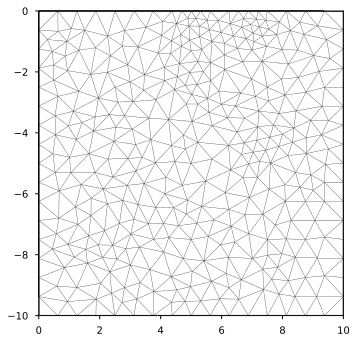

In [4]:
import pygimli.meshtools as mt
# We create a rectangular domain and mesh it with small triangles
rect = mt.createRectangle(start=[0, -10], end=[10, 0])
mesh = mt.createMesh(rect, quality=34.5, area=0.3)
print(mesh)
pg.show(mesh);

We define two positions where we associate two arbitrary values.

In [5]:
pos = [[3, -3], [7, -7]]
vals = np.array([20., 15.])
fop = PriorModelling(mesh, pos)

13/12/22 - 16:12:16 - pyGIMLi - INFO - Found 1 regions.


We set up an inversion instance with the forward operator and prepare the keywords for running the inversion always the same way:
- the data vector
- the error vector (as relative error)
- a starting model value (could also be vector)

In [6]:
inv = pg.Inversion(fop=fop, verbose=False)
invkw = dict(dataVals=vals, errorVals=np.ones_like(vals)*0.03, startModel=10)

## Classical smoothness constraints

13/12/22 - 16:12:16 - pyGIMLi - INFO - Creating forward mesh from region infos.


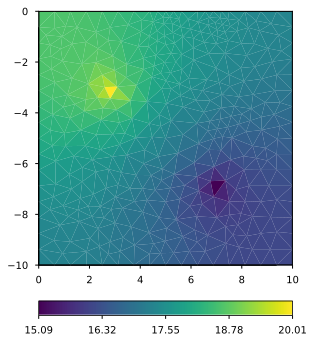

In [7]:
inv.setRegularization(cType=1)  # the default
result = inv.run(**invkw)
pg.show(mesh, result);

We will have a closer look at the regularization matrix C.

992 684 Mesh: Nodes: 377 Cells: 684 Boundaries: 1060


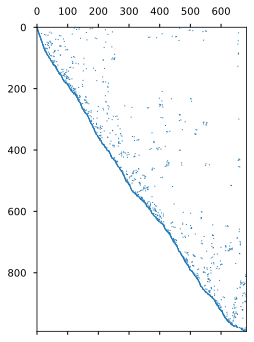

In [8]:
C = fop.constraints()
print(C.rows(), C.cols(), mesh)
ax, _ = pg.show(fop.constraints(), markersize=1);

In [9]:
row = C.row(111)
nz = np.nonzero(row)[0]
print(nz, row[nz])

[ 48 116] 2 [1.0, -1.0]


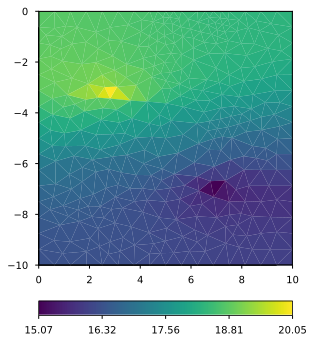

In [10]:
inv.setRegularization(cType=1, zWeight=0.2)  # the default
result = inv.run(**invkw)
pg.show(mesh, result);

In [11]:
RM=fop.regionManager()
cw = RM.constraintWeights()
print(min(cw), max(cw))

0.19999999999999996 1.0


Now we try some other regularization options.

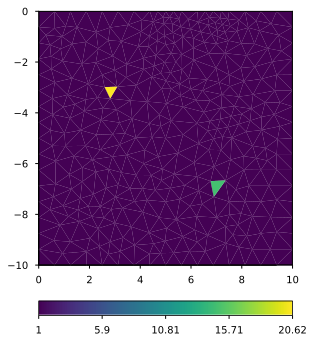

In [12]:
inv.setRegularization(cType=0)  # damping difference to starting model
result = inv.run(**invkw)
pg.show(mesh, result);

Obviously, the damping keeps the model small ($\log 1=0$) as the starting model is NOT a reference model by default. We will enable this by specifying the `isReference`  switch.

13/12/22 - 16:12:18 - pyGIMLi - INFO - Setting starting model as reference!


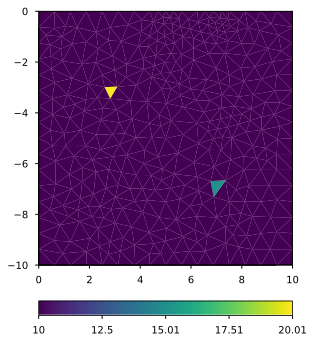

In [13]:
invkw["isReference"] = True
result = inv.run(**invkw)
pg.show(mesh, result);

13/12/22 - 16:12:18 - pyGIMLi - INFO - Setting starting model as reference!


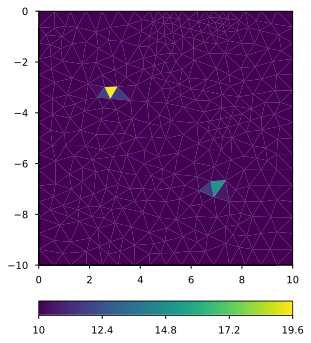

In [14]:
inv.setRegularization(cType=10)  # mix of 1st order smoothing and damping
result = inv.run(**invkw)
pg.show(mesh, result);

1676 684
Mesh: Nodes: 377 Cells: 684 Boundaries: 1060


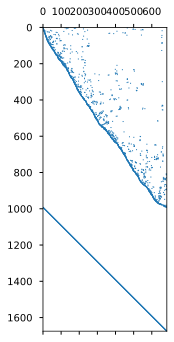

In [15]:
C = fop.constraints()
print(C.rows(), C.cols())
print(mesh)
pg.show(fop.constraints(), markersize=1);

We see that we have the first order smoothness and the identity matrix below each other. We can also use a second-order (-1 2 -1) smoothness operator by `cType=2`.

13/12/22 - 16:12:19 - pyGIMLi - INFO - Setting starting model as reference!


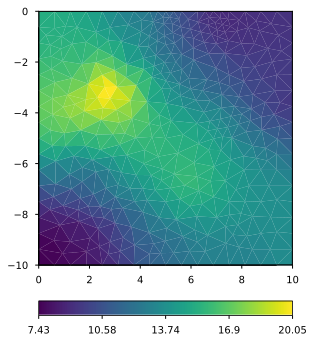

In [16]:
inv.setRegularization(cType=2)  # 2nd order smoothing
result = inv.run(**invkw)
pg.show(mesh, result);

684 684 Mesh: Nodes: 377 Cells: 684 Boundaries: 1060


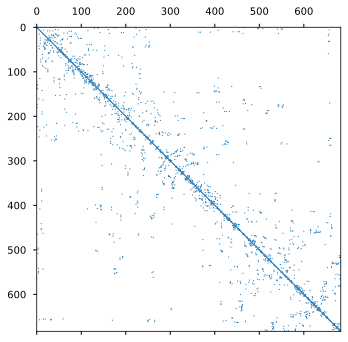

In [17]:
C = fop.constraints()
print(C.rows(), C.cols(), mesh)
pg.show(fop.constraints(), markersize=1);

It looks like a Laplace operator and seems to have a wider range compared to first-order smoothness.

## Geostatistic regularization

The idea is that not only neighbors are correlated to each other but to have a wider correlation by using an operator
$$    \textbf{C}_{\text{M},ij}=\sigma^{2}\exp{\left(
        -\sqrt{
        \left(\frac{\textbf{H}^x_{ij}}{I_{x}}\right)^{2}+
        \left(\frac{\textbf{H}^y_{ij}}{I_{y}}\right)^{2}
}\right)}.
$$

More details can be found in https://www.pygimli.org/_tutorials_auto/3_inversion/plot_6-geostatConstraints.html

137


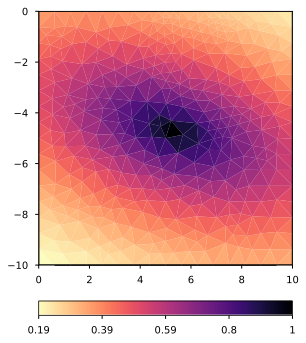

In [18]:
ind = mesh.findCell([5, -5]).id()
print(ind)
CM = pg.utils.covarianceMatrix(mesh, I=[8, 4], dip=-20) 
pg.show(mesh, CM[:, ind], cMap="magma_r");

In [19]:
C = pg.matrix.Cm05Matrix(CM)
print(C)

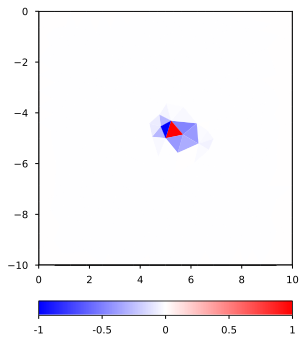

In [20]:
vec = pg.Vector(mesh.cellCount())
vec[ind] = 1.0
pg.show(mesh, C*vec, cMin=-1, cMax=1, cMap="bwr");

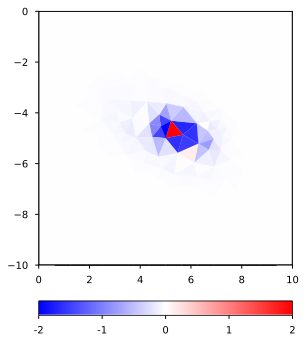

In [21]:
from  pygimli.core.math import symlog
pg.show(mesh, symlog(C*vec, 1e-2), cMin=-2, cMax=2, cMap="bwr");

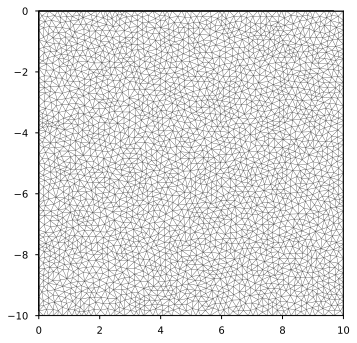

In [22]:
fineMesh = mt.createMesh(rect, area=0.03)
pg.show(fineMesh);

13/12/22 - 16:12:57 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 28.3s
13/12/22 - 16:12:58 - pyGIMLi - INFO - Cache stored: C:\Guenther.T\Anwendungsdaten\pygimli\Cache\2139474886824198204


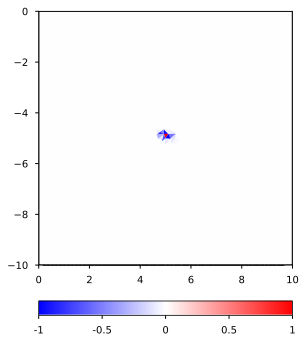

In [23]:
Cfine = pg.matrix.GeostatisticConstraintsMatrix(
    mesh=fineMesh, I=[8, 4], dip=-20)
indFine = fineMesh.findCell([5, -5]).id()
vec = pg.Vector(fineMesh.cellCount())
vec[indFine] = 1.0
pg.show(fineMesh, Cfine*vec, cMin=-1, cMax=1, cMap="bwr");

### Application

13/12/22 - 16:12:59 - pyGIMLi - INFO - Setting starting model as reference!
13/12/22 - 16:12:59 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 1 with: I=[2, 2, 2], dip=0, strike=0
13/12/22 - 16:12:59 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 0.1s
13/12/22 - 16:13:00 - pyGIMLi - INFO - Cache stored: C:\Guenther.T\Anwendungsdaten\pygimli\Cache\5706329621013424702


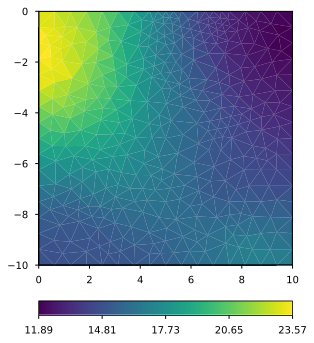

In [24]:
inv.setRegularization(correlationLengths=[2, 2, 2])
result = inv.run(**invkw)
pg.show(mesh, result);

This look structurally similar to the second-order smoothness, but can drive values outside the expected range in regions of no data coverage.

13/12/22 - 16:13:00 - pyGIMLi - INFO - Setting starting model as reference!
13/12/22 - 16:13:00 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 1 with: I=[2, 0.5, 2], dip=0, strike=0
13/12/22 - 16:13:00 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 0.1s
13/12/22 - 16:13:00 - pyGIMLi - INFO - Cache stored: C:\Guenther.T\Anwendungsdaten\pygimli\Cache\2031751371043172842


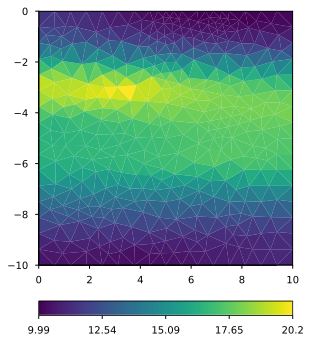

In [25]:
inv.setRegularization(correlationLengths=[2, 0.5, 2])
result = inv.run(**invkw)
pg.show(mesh, result);

13/12/22 - 16:13:01 - pyGIMLi - INFO - Setting starting model as reference!
13/12/22 - 16:13:01 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 1 with: I=[2, 0.5, 2], dip=-20, strike=0
13/12/22 - 16:13:01 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 0.1s
13/12/22 - 16:13:01 - pyGIMLi - INFO - Cache stored: C:\Guenther.T\Anwendungsdaten\pygimli\Cache\1192107577771169315


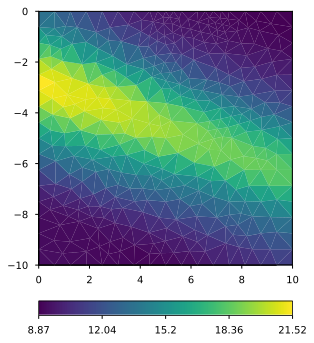

In [26]:
inv.setRegularization(correlationLengths=[2, 0.5, 2], dip=-20)
result = inv.run(**invkw)
pg.show(mesh, result);

We now add many more points.

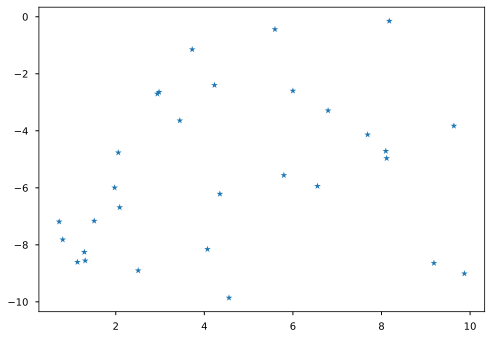

In [27]:
N = 30
x = np.random.rand(N) * 10
y = -np.random.rand(N) * 10
v = np.random.rand(N)*10 + 10
plt.plot(x, y, "*")

13/12/22 - 16:13:02 - pyGIMLi - INFO - Found 1 regions.
13/12/22 - 16:13:02 - pyGIMLi - INFO - Starting inversion.
13/12/22 - 16:13:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
13/12/22 - 16:13:02 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 1 with: I=[4, 4], dip=0, strike=0
13/12/22 - 16:13:03 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 0.1s
13/12/22 - 16:13:03 - pyGIMLi - INFO - Cache stored: C:\Guenther.T\Anwendungsdaten\pygimli\Cache\1960362745598751789


fop: <pygimli.frameworks.modelling.PriorModelling object at 0x00000202156949F0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000202198C8640>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000202198C82E0>
min/max (data): 10.14/19.58
min/max (error): 3%/3%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 0.97 (dPhi = 29.02%) lam: 20


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.97)                   #
################################################################################


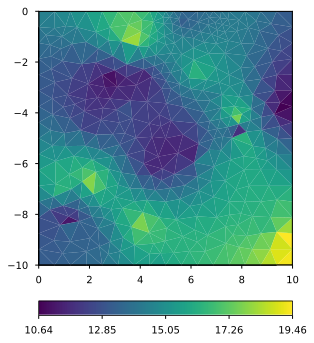

In [28]:
fop = PriorModelling(mesh, zip(x, y))
inv = pg.Inversion(fop=fop, verbose=True)
inv.setRegularization(correlationLengths=[4, 4])
result = inv.run(v, np.ones_like(v)*0.03, startModel=10)
pg.show(mesh, result);

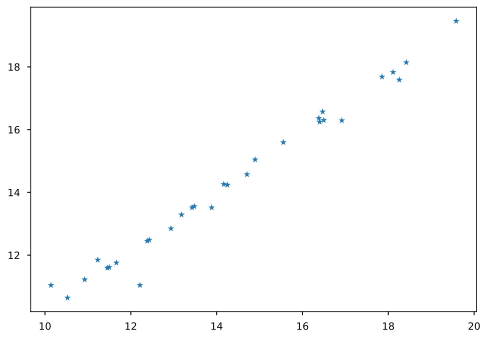

In [29]:
plt.plot(v, inv.response, "*");

## Individual regularization operators
Say you want to combine geostatistic operators with a damping, you can create a block matrix.

13/12/22 - 16:13:04 - pyGIMLi - INFO - Cache C:\Program Files\software\Anaconda\envs\pg13\lib\site-packages\pygimli\math\matrix.py:createCm05 restored (0.1s x 1): C:\Guenther.T\Anwendungsdaten\pygimli\Cache\1192107577771169315


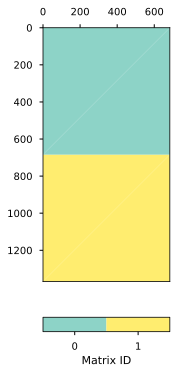

In [30]:
C = pg.matrix.BlockMatrix()
G = pg.matrix.GeostatisticConstraintsMatrix(mesh=mesh, I=[2, 0.5], dip=-20)
I = pg.matrix.IdentityMatrix(mesh.cellCount(), val=0.1)
C.addMatrix(G, 0, 0)
C.addMatrix(I, mesh.cellCount(), 0)
pg.show(C);

13/12/22 - 16:13:04 - pyGIMLi - INFO - Starting inversion.
13/12/22 - 16:13:04 - pyGIMLi - INFO - Setting starting model as reference!


fop: <pygimli.frameworks.modelling.PriorModelling object at 0x00000202156949F0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000202198C8B80>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000202198C8A00>
min/max (data): 10.14/19.58
min/max (error): 3%/3%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 0.67 (dPhi = 53.33%) lam: 20


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.67)                   #
################################################################################


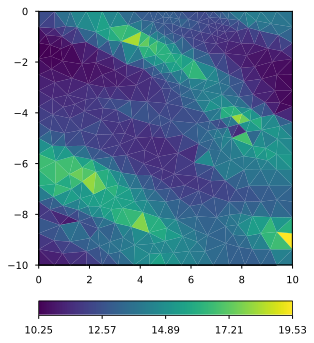

In [31]:
fop.setConstraints(C)
result = inv.run(v, np.ones_like(v)*0.03, startModel=10, isReference=True)
pg.show(mesh, result);

# Take-away messages
* regularization drives the model where data are weak
* think and play with your assumptions to the model 
* there are several predefined options
* geostatistic regularization can be superior
  - it is mesh-independent
  - it better fills the data gaps (e.g. 3D inversion of 2D profiles) 
  
Let's apply it to real data!